# NOTEBOOOK


***QUESTION 1 :  Are the variables stationary?***

In [2]:
#Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, VAR
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime
%matplotlib inline

In [3]:
#Load data
data= pd.read_excel('Data_HW2.xlsx')
data = data.drop(['Unnamed: 4', 'Unnamed: 5'], axis=1)
data = data.set_index('Date')

In [4]:
#Check the numbers of missing values 
count_nan = len(data) - data.count()
print(count_nan)
#There is no missing values 

lcons    0
temp     0
lprod    0
dtype: int64


Before undertaking any, data transformation or prediction, we checked if there were missing values in our data set. It seems there is no missing values to fill. 

In [5]:
#Transform the dataset into timeseries
ts1 = data['lcons']
ts2 = data['temp']
ts3 = data['lprod']

Text(0.5,1,'Log gas consumption')

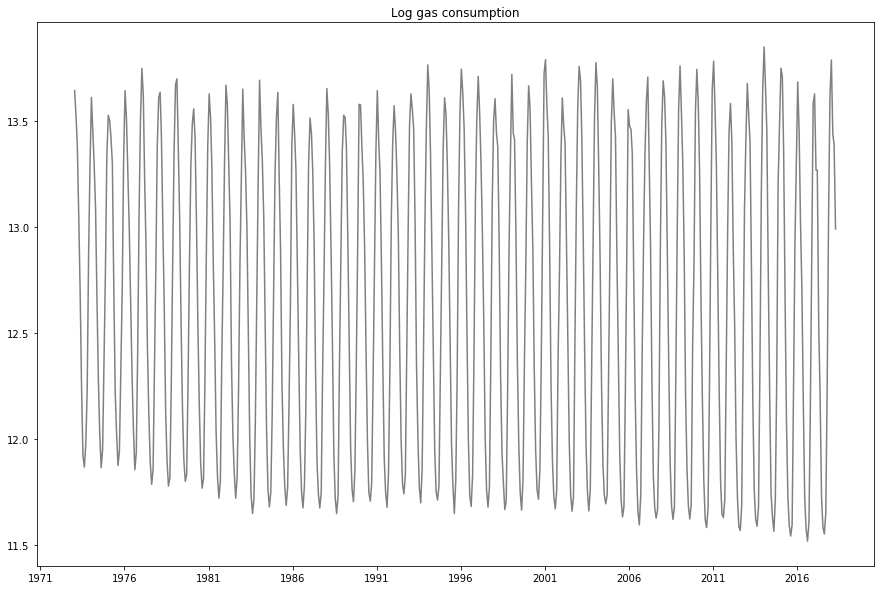

In [17]:
#Plot the Time Series of Log gas consumption 
plt.figure(figsize=(15,10))
plt.plot(ts1, color = 'grey')
plt.title('Log gas consumption')

In this plot, we consider the Logarithm tranformation of the gas consumption, probably in order to remove any trends or any increases in variation. We can notice that the Time Series seems to be stationary but it also seems that we are faced with seasonality. 

Text(0.5,1,'temperature')

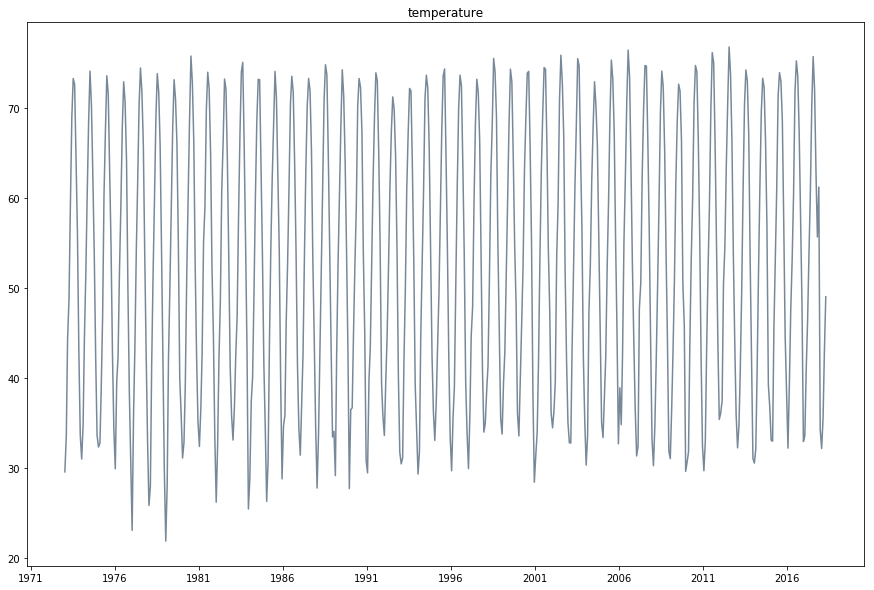

In [18]:
#Plot the Time Series of Temperature
plt.figure(figsize=(15,10))
plt.plot(ts2, color = 'lightslategrey')
plt.title('temperature')

This plot represents the Times Series of the average temperature in Farenheit in the US.  Time Series seems as constant as the log gas consumption even though no logarithm or differential transformation has been applied to remove trends. It also seems that there is seasonality. 

Text(0.5,1,'log industrial production')

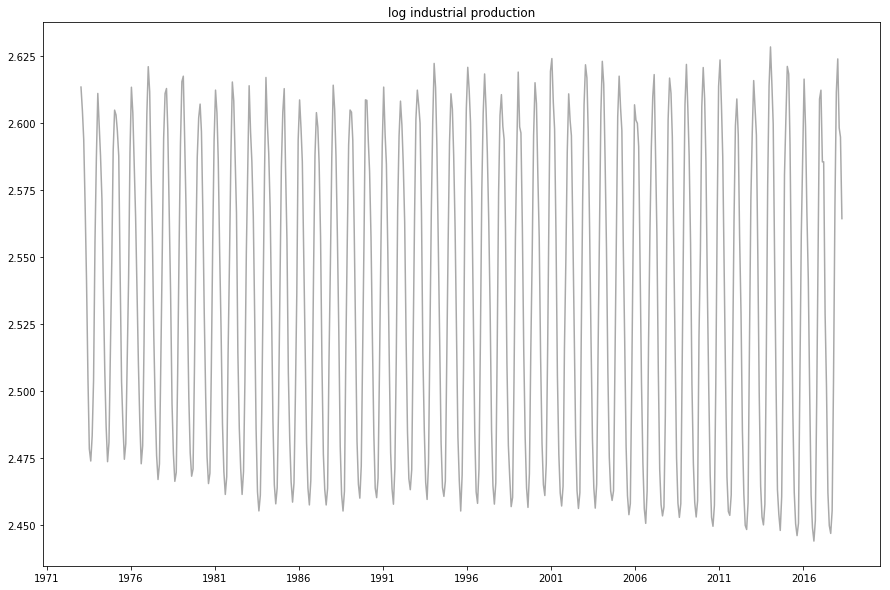

In [19]:
#Plot the Time Series of Log Industrial Production 
plt.figure(figsize=(15,10))
plt.plot(ts3, color = 'darkgrey')
plt.title('log industrial production')

The resulting plot is very cloosed to the log gas consumption one in terms of stationarity, variability and intensity. It is safe to assume that both variables are correlated. 

In [20]:
lag_acf1 = acf(ts1, nlags=20)
lag_acf2 = acf(ts2, nlags=20)
lag_acf3 = acf(ts3, nlags=20)

Text(0.5,1,'Autocorrelation Function log Gaz Consumption')

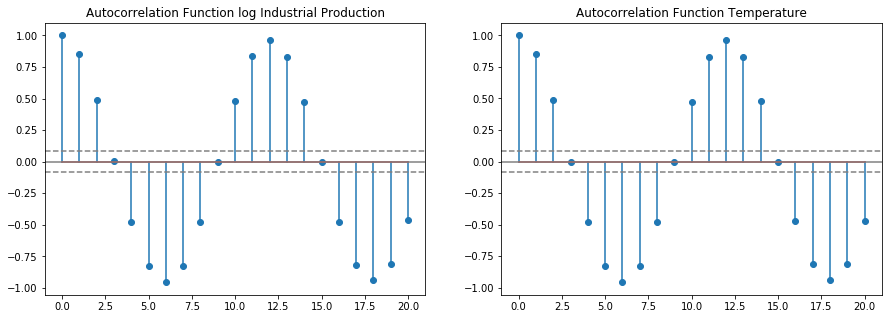

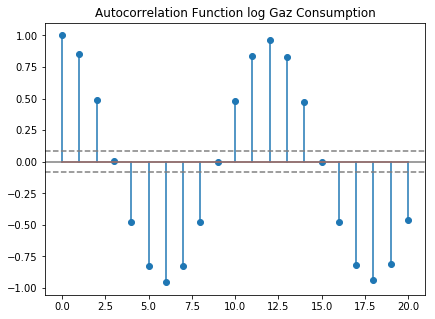

In [21]:
#Plot ACF: 
plt.figure(figsize = (15, 5)) 
plt.subplot(121)
plt.stem(lag_acf3)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function log Industrial Production')


plt.subplot(122)
plt.stem(lag_acf2)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function Temperature')

plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.stem(lag_acf1)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts1)),linestyle='--',color='gray')
plt.title('Autocorrelation Function log Gaz Consumption')


We plotted ACF to ensure our assumptions concerning stationarity and seasonality. Indeed looking at the ACFs, we can detect for the three variables, a seasonal pattern with T = 6 months. Thus, those variables are not stationary because they depend to the time at which they are observed. Moreover, the values of the ACF function are actually very large, the correlation is strong. 

***QUESTION 2 : Exponential Smoothing and Holt-Winters.***

In [22]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

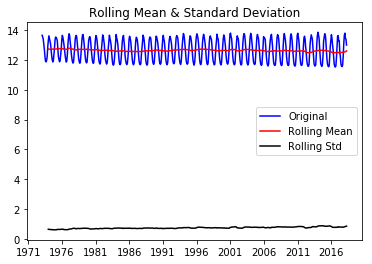

Results of Dickey-Fuller Test:
Test Statistic                  -3.030399
p-value                          0.032151
#Lags Used                      13.000000
Number of Observations Used    530.000000
Critical Value (1%)             -3.442749
Critical Value (5%)             -2.867009
Critical Value (10%)            -2.569683
dtype: float64


In [23]:
test_stationarity(ts1)

Before undertaking any test, we wanted to perform a Dickey-Fuller test to see if those seasonality effects are too strong to jeopardize the stationarity condition for the application of our model. According to the Dickey Fuller test, the time series is stationary enough with a slowly varying mean (thanks to the log transformation), despite the seasonalities,. Thus, we can apply models such as Exponential Smoothing or Holt-Winters.

In [24]:
#Creating train and test set
#10% of dataset used to test the model
train=ts1[:'2014-01-15'] 
test=ts1['2014-01-15':]

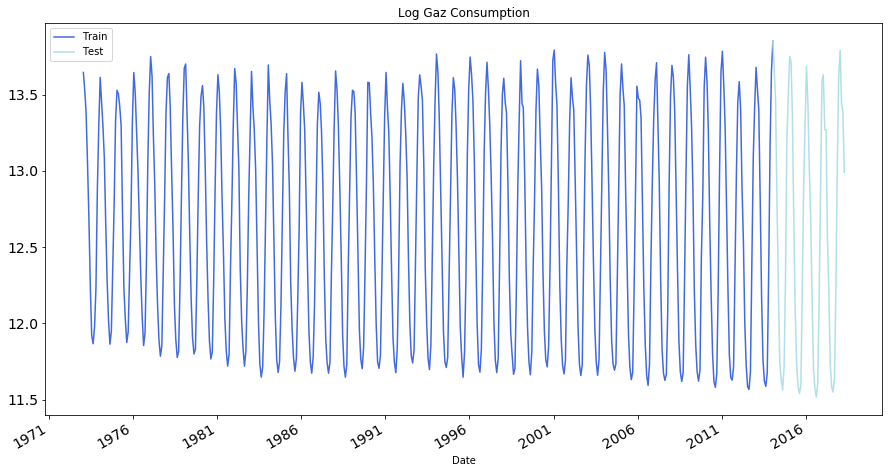

In [25]:
#Plotting data
train.plot(figsize=(15,8), title= 'Log Gaz Consumption', fontsize=14, color = 'royalblue', label = 'Train')
test.plot(figsize=(15,8), title= 'Log Gaz Consumption', fontsize=14, color = 'powderblue', label = 'Test')
plt.legend(loc='best')
plt.show()

We decided to dedicate 90% of the data set to train our model and 10% to test it. Thus our training data are observations from 1973-01-15 to 2014-01-14 and our test data contained observations from 2014-01-15 to 2018-04-15.
In the plot above, the dark blue curve is from the training set and the light blue one from the test set. 

/Users/jennifervial/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jennifervial/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


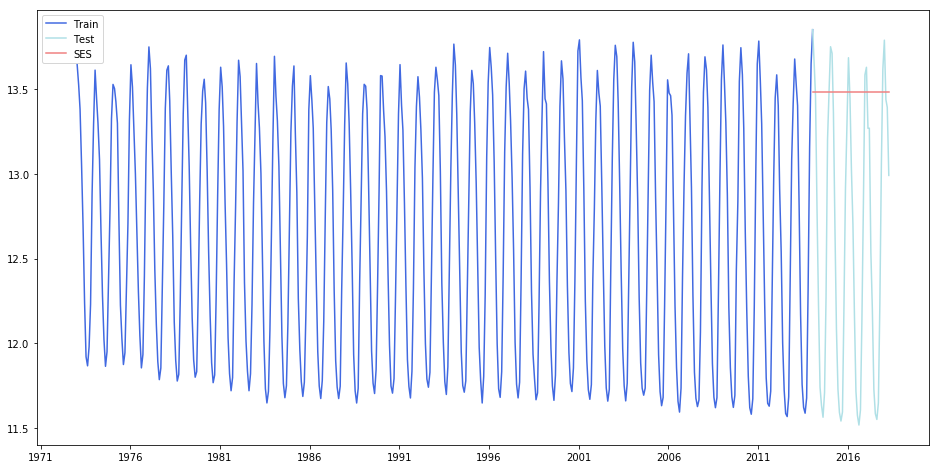

In [26]:
y_hat_exp = data['2014-01-15':].copy()
fit2 = SimpleExpSmoothing(train).fit(smoothing_level=0.5,optimized=False)
y_hat_exp['lcons'] = fit2.forecast(len(test)).values
plt.figure(figsize=(16,8))
plt.plot(train, label='Train', color = 'royalblue')
plt.plot(test, label='Test', color = 'powderblue')
plt.plot(y_hat_exp['lcons'], label='SES', color = 'lightcoral')
plt.legend(loc='best')


In [27]:
rms_exp = sqrt(mean_squared_error(test, y_hat_exp['lcons']))
print('Mean Squarred Error for Exponential Smoothing =',rms_exp)

Mean Squarred Error for Exponential Smoothing = 1.188471965285003


We fit our exponential smoothing that is represented by the red lign. Our Mean Squarred Error is up to 1.188. Let's try the Holt Winter model in order to check which one has the less Mean Squarred Error. 

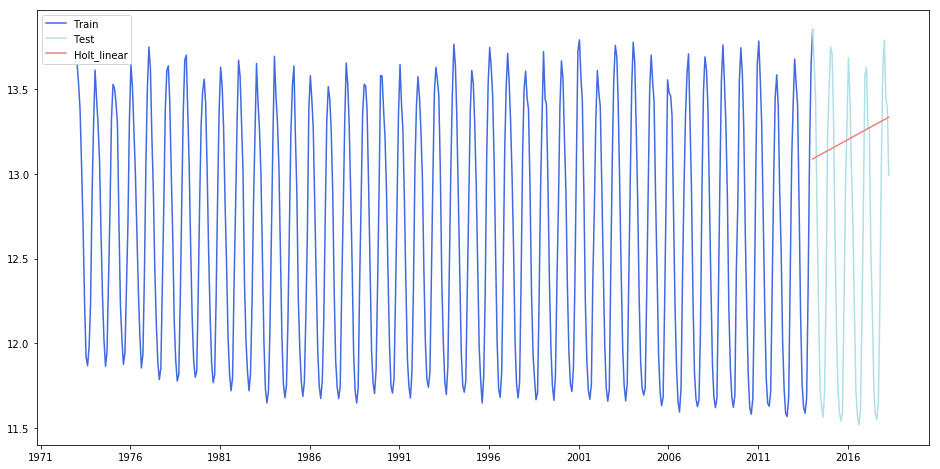

In [28]:
y_hat_holt = data['2014-01-15':].copy()
fit3 = Holt(np.asarray(train)).fit(smoothing_level = 0.3, smoothing_slope = 0.01)
y_hat_holt['lcons']  = fit3.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train, label='Train', color = 'royalblue')
plt.plot(test, label='Test', color = 'powderblue')
plt.plot(y_hat_holt['lcons'], label='Holt_linear', color = 'lightcoral')
plt.legend(loc='best')
plt.show()

In [29]:
rms_holt = sqrt(mean_squared_error(test, y_hat_holt['lcons']))
print('Mean Squarred Error for Holt-Winters =',rms_holt)

Mean Squarred Error for Holt-Winters = 1.0077015657200084


Our Holt Winter model has a Mean Squared error of about 1.0077, it seems that this model is more efficient that the exponential smoothing one. It is not really wonder to the extend that Holt Winter is a type of Exponential Smoothing which is supposed to capture seasonality effects. Let's try a SARIMA model to see if we can deal with seasonality even better. 

***SARIMA***

/Users/jennifervial/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/jennifervial/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


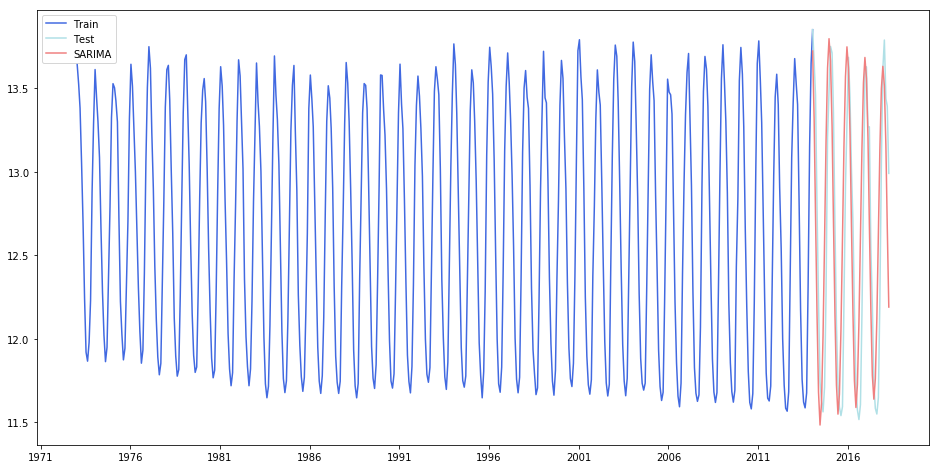

In [30]:
y_hat_sarimax = data['2014-01-15':].copy()
fit1 = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 2),seasonal_order=(0,1,1,7), enforce_invertibility=False).fit()
y_hat_sarimax['lcons'] = fit1.predict(start=493, end=544, dynamic=True).values
plt.figure(figsize=(16,8))
plt.plot( train, label='Train', color = 'royalblue')
plt.plot(test, label='Test', color = 'powderblue')
plt.plot(y_hat_sarimax['lcons'], label='SARIMA', color = 'lightcoral')
plt.legend(loc='best')
plt.show()

In [19]:
rms_sarimax = sqrt(mean_squared_error(test, y_hat_sarimax['lcons']))
print(rms_sarimax)

0.5404748705285032


Through the plot and the RMS we can notice that the SARIMA seems to be much better performant than the Holt-Winter and the Exponential Smoothing models. We modelized our Times Series through its seasonalities, nevertheless, we noticed on the introduction plots that it is highly likely that our log gas consumption Time Series is correlated with temperature Times series and log Industrial production Times series. We are gone to modelize this idea through a VAR model. 

***VAR***

C:\Users\Romain Marsal\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


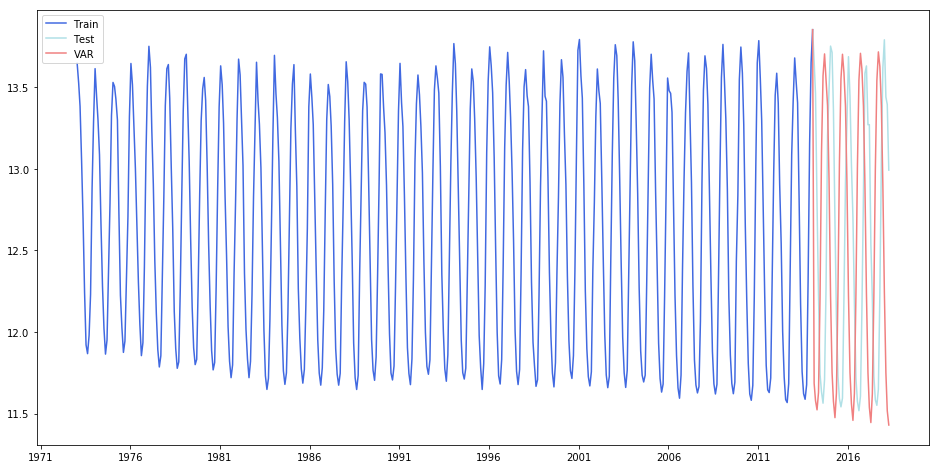

In [89]:
y_hat_var = data['2014-01-15':].copy()
model = VAR(data[:'2014-01-15'])
fit3 = model.fit(maxlags=12, ic='aic')
lag_order = fit3.k_ar
#print(fit3.forecast(data['2014-01-15':].values[-lag_order:], 52)[:, 0].shape)
y_hat_var['lcons']  = fit3.forecast(data['2014-01-15':].values[-lag_order:], 52)[:, 0]
y_hat_var['lcons'][0] = train[-1]
plt.figure(figsize=(16,8))
plt.plot(train, label='Train', color = 'royalblue')
plt.plot(test, label='Test', color = 'powderblue')
plt.plot(y_hat_var['lcons'], label='VAR', color = 'lightcoral')
plt.legend(loc='best')
plt.show()

In [90]:
rms_var = sqrt(mean_squared_error(test, y_hat_var['lcons']))
print(rms_var)

1.3976265317762524


It seems that our VAR model is less performant than our SARIMA. Let's make a Diebold Mariona Test to check this idea. 

***Question 3 : Diebold Marino Test.***

In [94]:
rt = dm_test(data.lcons['2014-01-15':], y_hat_sarimax['lcons'], y_hat_holt['lcons'],h = 1, crit="MSE")
print('SARIMAX Vs. Holt-Winters',rt)

rt2 = dm_test(data.lcons['2014-01-15':], y_hat_sarimax['lcons'], y_hat_exp['lcons'],h = 1, crit="MSE")
print('SARIMAX Vs. Exponentional Smoothing',rt2)

rt2 = dm_test(data.lcons['2014-01-15':], y_hat_sarimax['lcons'], y_hat_var['lcons'],h = 1, crit="MSE")
print('SARIMAX Vs. VAR',rt2)

SARIMAX Vs. Holt-Winters dm_return(DM=-4.867589719384931, p_value=1.1311296979673567e-05)
SARIMAX Vs. Exponentional Smoothing dm_return(DM=-5.520426994182094, p_value=1.144632731237889e-06)
SARIMAX Vs. VAR dm_return(DM=-8.89034471607697, p_value=6.070570823247689e-12)


According to the Diebold Marino Test, the SARIMA is indeed, the one which performs the best. That's the one we recommend. 

***Question 4 : out-of-sample forecasts for May-September 2018 with SARIMA.***

In [20]:
array = np.array(['0','0','0','0','0','0', '0'])
indexes =['2018-04-15' ,'2018-05-15','2018-06-15','2018-07-15','2018-08-15','2018-09-15','2018-10-15']
dates = [datetime.strptime(x, '%Y-%m-%d') for x in indexes]
predict = pd.Series(array,index=dates)
predict


2018-04-15    0
2018-05-15    0
2018-06-15    0
2018-07-15    0
2018-08-15    0
2018-09-15    0
2018-10-15    0
dtype: object

C:\Users\Romain Marsal\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Romain Marsal\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


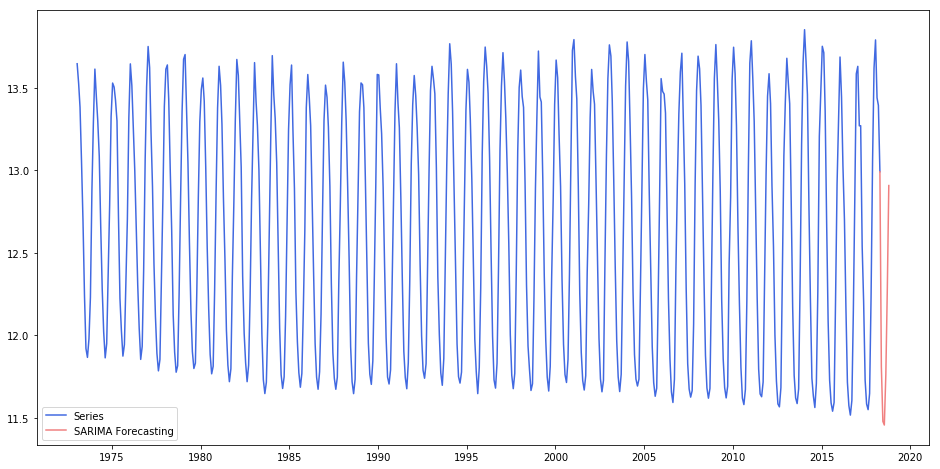

In [21]:
fit1 = sm.tsa.statespace.SARIMAX(ts1, order=(2, 1, 2),seasonal_order=(0,1,1,7), enforce_invertibility=False).fit()
array = fit1.predict(start=544, end=550, dynamic=True).values
predict = pd.Series(array,index=dates)
predict[0] = ts1[-1]
plt.figure(figsize=(16,8))
plt.plot( ts1, label='Series', color = 'royalblue')
plt.plot(predict, label='SARIMA Forecasting', color = 'lightcoral')
plt.legend(loc='best')
plt.show()

In [26]:
fcast = fit1.get_forecast(7)
print('Forecast:')
print(fcast.predicted_mean)
print('Confidence intervals at 95%:')
print(fcast.conf_int())

Forecast:
544    12.375428
545    11.811254
546    11.479645
547    11.457353
548    11.762290
549    12.289007
550    12.907965
dtype: float64
Confidence intervals at 95%:
     lower lcons  upper lcons
544    12.145130    12.605727
545    11.497606    12.124902
546    11.131138    11.828152
547    11.103045    11.811660
548    11.406940    12.117641
549    11.920536    12.657478
550    12.517931    13.298000


C:\Users\Romain Marsal\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


We give above the uncertainty of the forecast, which is encouraging. The intervals for each parameters quite tight and we can predict with a good accuracy the consumtion of Gaz for the next 6 months. We have lower estimations and upper estimations. It seems that consumption of gaz will decrease down to about 11,5 to increase again. It is not really wonder, as we have seen above, gaz consumption is submitted to seasonality. 